In [3]:
conda install pytorch torchvision torchaudio -c pytorch

Channels:
 - pytorch
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries for data processing and model training
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import torchvision.transforms as T
import seaborn as sns


In [2]:
# Setting up the device for GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Data augmentation and transformation for training and testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Loading dataset and splitting into train, validation, and test sets
data_dir = '/Users/nisar/Downloads/Akhila/Dataset-1/'
full_data = datasets.ImageFolder(data_dir, transform=train_transforms)

# Splitting data into training and validation sets
dataset_size = len(full_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# DataLoader creation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32)

# Displaying counts
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Testing samples: {len(test_data)}")

Training samples: 4733, Validation samples: 1184, Testing samples: 5917


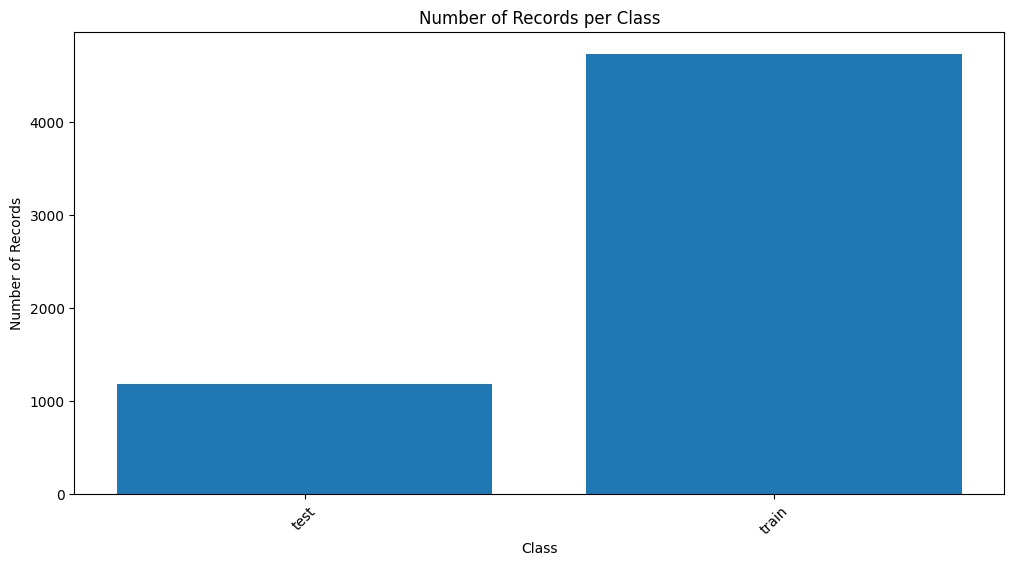

In [6]:
# Counting records per class and plotting
class_counts = {class_name: 0 for class_name in test_loader.dataset.classes}
for _, label in test_loader.dataset.samples:
    class_name = test_loader.dataset.classes[label]
    class_counts[class_name] += 1

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Number of Records per Class')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Load pre-trained ResNet18 model and modify the final layer
resnet18 = models.resnet18(pretrained=True)

c:\Users\nisar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nisar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

# Fine-tuning layers selectively (freeze some layers)
for name, param in resnet18.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_classes = len(test_loader.dataset.classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)  # Modify output layer for classification

In [9]:

# Move model to device (GPU/CPU)
resnet18 = resnet18.to(device)

In [10]:

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)

In [13]:

# Training loop setup
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    resnet18.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    resnet18.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet18(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_corrects += (val_preds == val_labels).sum().item()
            val_samples += val_labels.size(0)

    val_epoch_loss = val_loss / val_samples
    val_epoch_accuracy = val_corrects / val_samples
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy*100:.2f}%")

Epoch 1/10, Train Loss: 0.3582, Train Accuracy: 84.79%, Val Loss: 0.8279, Val Accuracy: 75.76%
Epoch 2/10, Train Loss: 0.3232, Train Accuracy: 85.93%, Val Loss: 0.8205, Val Accuracy: 76.94%
Epoch 3/10, Train Loss: 0.2837, Train Accuracy: 88.19%, Val Loss: 0.8176, Val Accuracy: 70.86%
Epoch 4/10, Train Loss: 0.2478, Train Accuracy: 89.73%, Val Loss: 0.9460, Val Accuracy: 74.83%
Epoch 5/10, Train Loss: 0.2359, Train Accuracy: 90.56%, Val Loss: 0.9357, Val Accuracy: 74.41%
Epoch 6/10, Train Loss: 0.2116, Train Accuracy: 91.04%, Val Loss: 0.9441, Val Accuracy: 70.69%
Epoch 7/10, Train Loss: 0.1931, Train Accuracy: 92.39%, Val Loss: 0.9975, Val Accuracy: 72.38%
Epoch 8/10, Train Loss: 0.1861, Train Accuracy: 92.20%, Val Loss: 1.0788, Val Accuracy: 73.14%
Epoch 9/10, Train Loss: 0.1606, Train Accuracy: 93.18%, Val Loss: 1.0952, Val Accuracy: 69.51%
Epoch 10/10, Train Loss: 0.1466, Train Accuracy: 94.06%, Val Loss: 1.0669, Val Accuracy: 69.93%


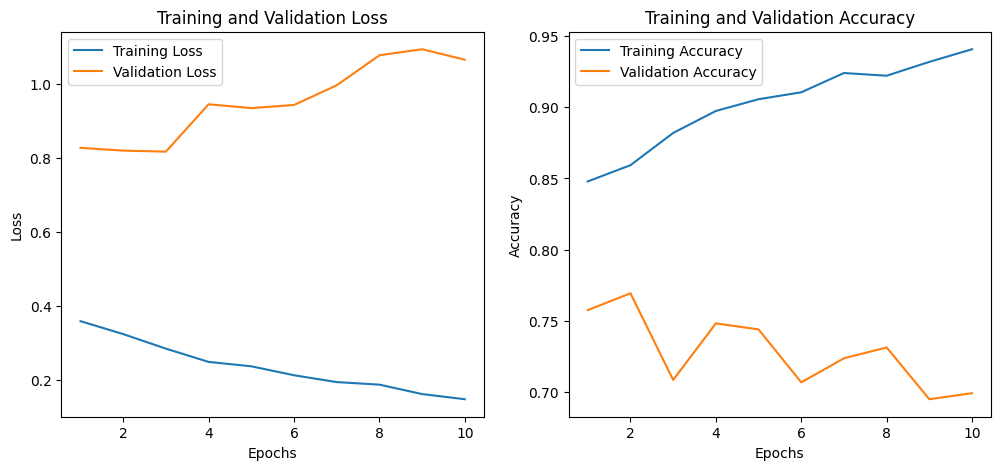

In [14]:

# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [15]:

# Model evaluation on test data
resnet18.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [16]:

# Performance metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Test Accuracy: 90.74%
Precision: 90.57%
Recall: 90.74%
F1 Score: 90.63%


In [18]:

# Visualizing features using t-SNE
features = np.array(all_preds)
labels = np.array(all_labels)
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Visualization of Test Features")
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 1. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:

# Confusion matrix
def test_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

conf_matrix = test_model(resnet18, test_loader, device)
class_names = test_loader.dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for ResNet18 Model')
plt.show()